## Apply the Markov Model and calculated Transition Probabilities along-with the proposed conversion probabilities to a campaign


## Import libraries

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.4)


In [0]:
database_name = "MultiTouch"
raw_data_path = "/mnt/da-global-raw-box/POC/MultiTouch"
bronze_tbl_path = "/mnt/da-global-raw-box/POC/MultiTouchBronze"

gold_user_journey_tbl_path = "/mnt/da-global-raw-box/POC/MultiTouchGoldUserJourney"
gold_attribution_tbl_path = "/mnt/da-global-raw-box/POC/MultiTouchGoldAttributes"
gold_ad_spend_tbl_path = "/mnt/da-global-raw-box/POC/MultiTouchGoldAdSpend"

project_directory = "/mnt/da-global-raw-box/POC/MultiTouchProject"

## Set the current database so that it doesn't need to be manually specified each time it's used


In [0]:
_ = spark.sql("use {}".format(database_name))

## Create and Populate Ad Spend Table
1. Create ad spend table
2. Create widget for specifying the ad spend for a given campaign
3. Populate ad spend table with synthetic spend data
4. View campaign ad spend details
5. Explode struct into multiple rows

## Create ad spend table

In [0]:
_ = spark.sql('''
  CREATE OR REPLACE TABLE gold_ad_spend (
    campaign_id STRING, 
    total_spend FLOAT, 
    channel_spend MAP<STRING, FLOAT>, 
    campaign_start_date TIMESTAMP)
  USING DELTA
  LOCATION '{}'
  '''.format(gold_ad_spend_tbl_path))

## Create widget for specifying the ad spend for a given campaign
* In practice, this data is typically captured directly from each marketing activation channel.


In [0]:
dbutils.widgets.text("adspend", "10000", "Campaign Budget in $")

## Populate ad spend table with synthetic ad spend data
* Note that the value for the widget is passed in using $adspend
* For illustration purposes, we have distributed spend uniformly across all marketing channels (20%)

In [0]:
%sql
INSERT INTO TABLE gold_ad_spend
VALUES ("3d65f7e92e81480cac52a20dfdf64d5b", int($adspend),
          MAP('Social Network', .2,
              'Search Engine Marketing', .2,  
              'Google Display Network', .2, 
              'Affiliates', .2, 
              'Email', .2), 
         make_timestamp(2020, 5, 17, 0, 0, 0));

## View campaign ad spend details
* The channel spend data currently exists as an array. We will explode these values into separate columns in the next step

In [0]:
%sql
SELECT * FROM gold_ad_spend

campaign_id,total_spend,channel_spend,campaign_start_date
3d65f7e92e81480cac52a20dfdf64d5b,10000.0,"Map(Search Engine Marketing -> 0.2, Email -> 0.2, Social Network -> 0.2, Affiliates -> 0.2, Google Display Network -> 0.2)",2020-05-17T00:00:00.000+0000


## Explode struct into multiple rows

We'll start by assuming that the ad-spend is divided equally across each channel

In [0]:
ad_spend_df = spark.sql('select explode(channel_spend) as (channel, pct_spend), \
                         round(total_spend * pct_spend, 2) as spend \
                         from gold_ad_spend')

ad_spend_df.createOrReplaceTempView("exploded_gold_ad_spend")
display(ad_spend_df)

channel,pct_spend,spend
Social Network,0.2,2000.0
Search Engine Marketing,0.2,2000.0
Google Display Network,0.2,2000.0
Affiliates,0.2,2000.0
Email,0.2,2000.0


## View Campaign Performance

1. Base conversion rate
2. Conversions by date
3. Attribution by model type
4. Cost per acquisition

## Base conversion rate

Based on historical data, what percentage of touches result in a conversion?

In [0]:
%sql
CREATE OR REPLACE TABLE base_conversion_rate
USING DELTA AS
SELECT count(*) as count,
  CASE 
    WHEN conversion == 0 
    THEN 'Impression'
    ELSE 'Conversion'
  END AS interaction_type
FROM
  gold_user_journey
GROUP BY
  conversion;

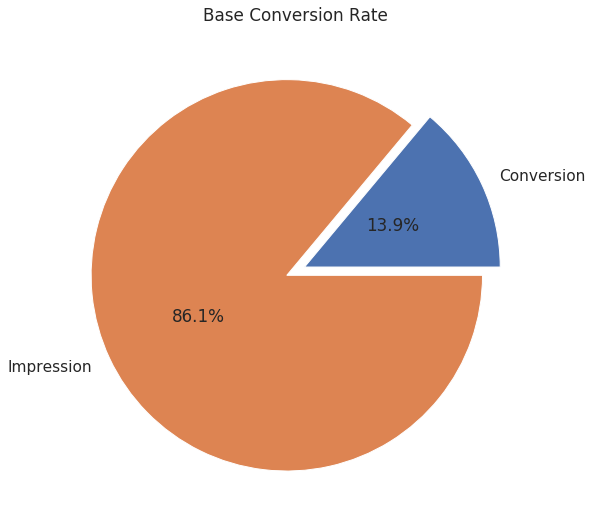

In [0]:
base_converion_rate_pd = spark.table("base_conversion_rate").toPandas()

pie, ax = plt.subplots(figsize=[20,9])
labels = base_converion_rate_pd['interaction_type']
plt.pie(x=base_converion_rate_pd['count'], autopct="%.1f%%", explode=[0.05]*2, labels=labels, pctdistance=0.5)
plt.title("Base Conversion Rate");

##  Conversions by date

How have these conversions changes over time?

In [0]:
%sql
CREATE OR REPLACE TABLE conversions_by_date 
USING DELTA AS
SELECT count(*) AS count,
  'Conversion' AS interaction_type,
  date(time) AS date
FROM bronze
WHERE conversion = 1
GROUP BY date
ORDER BY date;

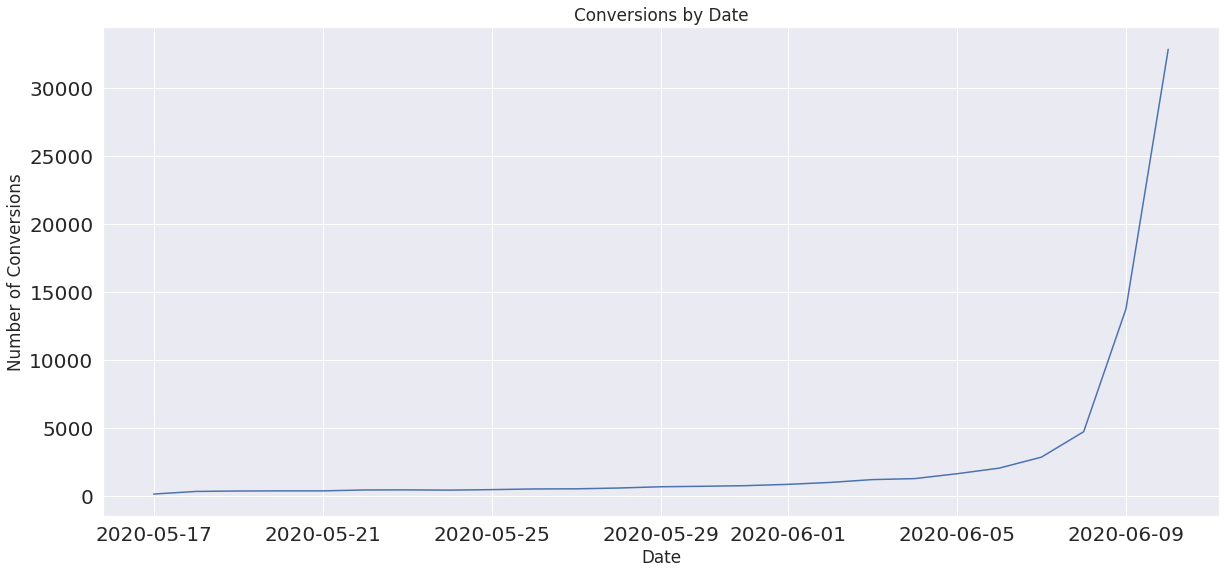

In [0]:
conversions_by_date_pd = spark.table("conversions_by_date").toPandas()

plt.figure(figsize=(20,9))
pt = sns.lineplot(x='date',y='count',data=conversions_by_date_pd)

pt.tick_params(labelsize=20)
pt.set_xlabel('Date')
pt.set_ylabel('Number of Conversions')
plt.title("Conversions by Date");

##  Attribution by Model (First, Last and Markov)

How many conversions per touch point whne defined as either the first, last or predicted markov?

In [0]:
%sql
CREATE OR REPLACE TABLE attribution_by_model_type 
USING DELTA AS
SELECT attribution_model, channel, round(attribution_percent * (
    SELECT count(*) FROM gold_user_journey WHERE conversion = 1)) AS conversions_attributed
FROM gold_attribution;

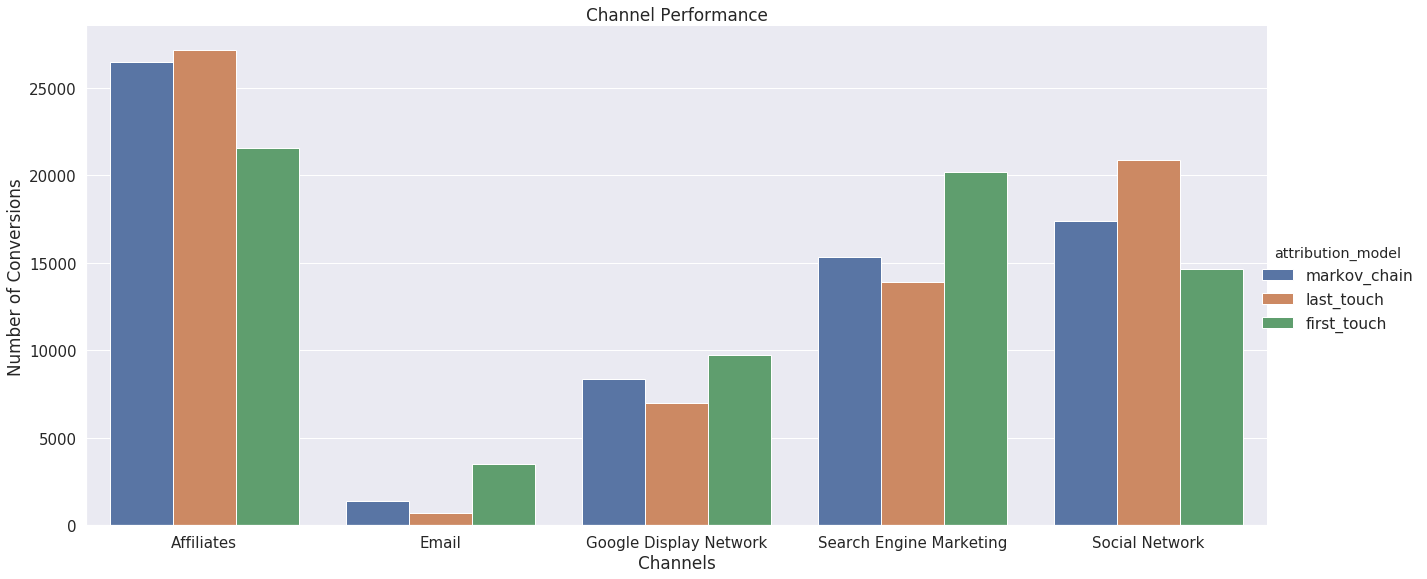

In [0]:
attribution_by_model_type_pd = spark.table("attribution_by_model_type").toPandas()

pt = sns.catplot(x='channel',y='conversions_attributed',hue='attribution_model',data=attribution_by_model_type_pd, kind='bar', aspect=4, legend=True)
pt.fig.set_figwidth(20)
pt.fig.set_figheight(9)

plt.tick_params(labelsize=15)
plt.ylabel("Number of Conversions")
plt.xlabel("Channels")
plt.title("Channel Performance");

##  Cost per acquisition

In [0]:
%sql 
CREATE OR REPLACE TABLE cpa_summary 
USING DELTA
AS
SELECT
  spending.channel,
  spending.monetry_spend,
  attribution_count.attribution_model,
  attribution_count.conversions_attributed,
  round(spending.monetry_spend / attribution_count.conversions_attributed,2) AS CPA_amount
FROM
  (SELECT explode(channel_spend) AS (channel, spend),
   round(total_spend * spend, 2) AS monetry_spend
   FROM gold_ad_spend) AS spending
JOIN
  (SELECT attribution_model, channel, round(attribution_percent * (
      SELECT count(*) FROM gold_user_journey WHERE conversion = 1)) AS conversions_attributed
   FROM gold_attribution) AS attribution_count
ON spending.channel = attribution_count.channel;

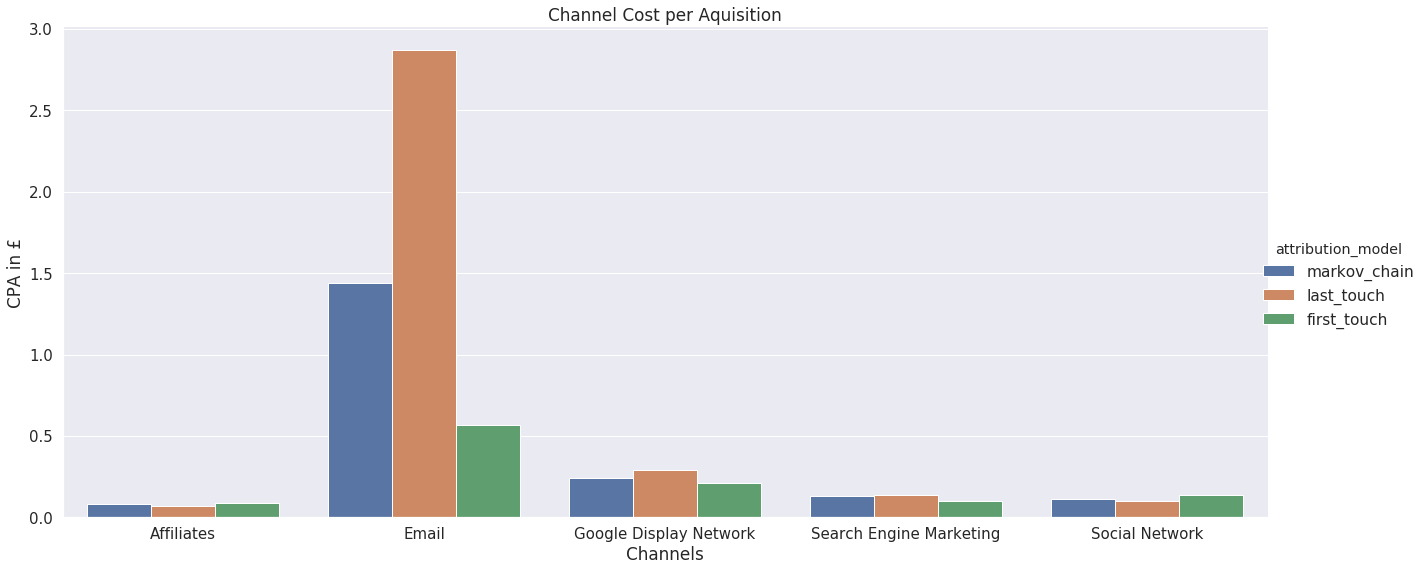

In [0]:
cpa_summary_pd = spark.table("cpa_summary").toPandas()

pt = sns.catplot(x='channel', y='CPA_amount',hue='attribution_model',data=cpa_summary_pd, kind='bar', aspect=4, ci=None)
plt.title("Cost of Aquisition by Channel")
pt.fig.set_figwidth(20)
pt.fig.set_figheight(9)

plt.tick_params(labelsize=15)
plt.ylabel("CPA in £")
plt.xlabel("Channels")
plt.title("Channel Cost per Aquisition");

## Budget Allocation Optimization.
Now that we have assigned credit to our marketing channels using Markov Chains, we can take a data-driven approach for budget allocation.

* One KPI we can take a look at is Return on Ad Spend (ROAS).
* In the ecommerce world, ROAS is calculated as: <br>
``ROAS = Revenue £ from marketing/ Advertising £ spent``

In our example, instead of working with exact £ values, we will divide the % of conversion attributed to a channel by the % of total adspend allocated to that channel.
* ``ROAS = CHANNEL CONVERSION WEIGHT / CHANNEL BUDGET WEIGHT``
  * ROAS value > 1 signifies that the channel has been allocated less budget than warranted by its conversion rate.
  * ROAS value < 1 signifies that the channel has been allocated more budget than warranted by its conversion rate.
  * ROAS value = 1 signifies and optimized budget allocation. 

From ROAS, we can calculate the Proposed Budget for each channel <br>
* ``Proposed budget =  Current budget X ROAS``
<br>

To calculate ROAS we will join the following Delta Tables:
* **gold_attribution:** This table contains the calculated attribution % per channel based on different attribution models.
* **exploded_gold_ad_spend:** This table contains the current budget allocated per channel. The column pct_spend documents the % of the total budget that has been allocated to a given channel. 

#### We start by assuming that the current campaign ad spend is divided equally across all channels

In [0]:
%sql
SELECT * FROM exploded_gold_ad_spend;

channel,pct_spend,spend
Social Network,0.2,2000.0
Search Engine Marketing,0.2,2000.0
Google Display Network,0.2,2000.0
Affiliates,0.2,2000.0
Email,0.2,2000.0


#### Reminder of what touchpoints/channels did the model recommend as offering the greatest return

In [0]:
%sql
SELECT * FROM gold_attribution;

attribution_model,channel,attribution_percent
last_touch,Search Engine Marketing,0.2
last_touch,Social Network,0.3
last_touch,Affiliates,0.39
last_touch,Google Display Network,0.1
last_touch,Email,0.01
first_touch,Email,0.05
first_touch,Google Display Network,0.14
first_touch,Social Network,0.21
first_touch,Search Engine Marketing,0.29
first_touch,Affiliates,0.31


In [0]:
%sql
CREATE OR REPLACE TABLE spend_optimisation_view 
USING DELTA
AS
SELECT
  a.channel,
  a.pct_spend,
  b.attribution_percent,
  b.attribution_percent / a.pct_spend as ROAS,
  a.spend,
  round(
    (b.attribution_percent / a.pct_spend) * a.spend,
    2
  ) as proposed_monetry_spend
FROM
  exploded_gold_ad_spend a
  JOIN gold_attribution b on a.channel = b.channel
  and attribution_model = 'markov_chain';
  
CREATE
OR REPLACE TABLE spend_optimisation_final 
USING DELTA AS
SELECT
  channel,
  'current_spending' AS spending,
  spend as budget
 FROM exploded_gold_ad_spend
UNION
SELECT
  channel,
  'proposed_spending' AS spending,
  proposed_monetry_spend as budget
FROM
  spend_optimisation_view;  

#### What is the recommended ad-spend split across all channels

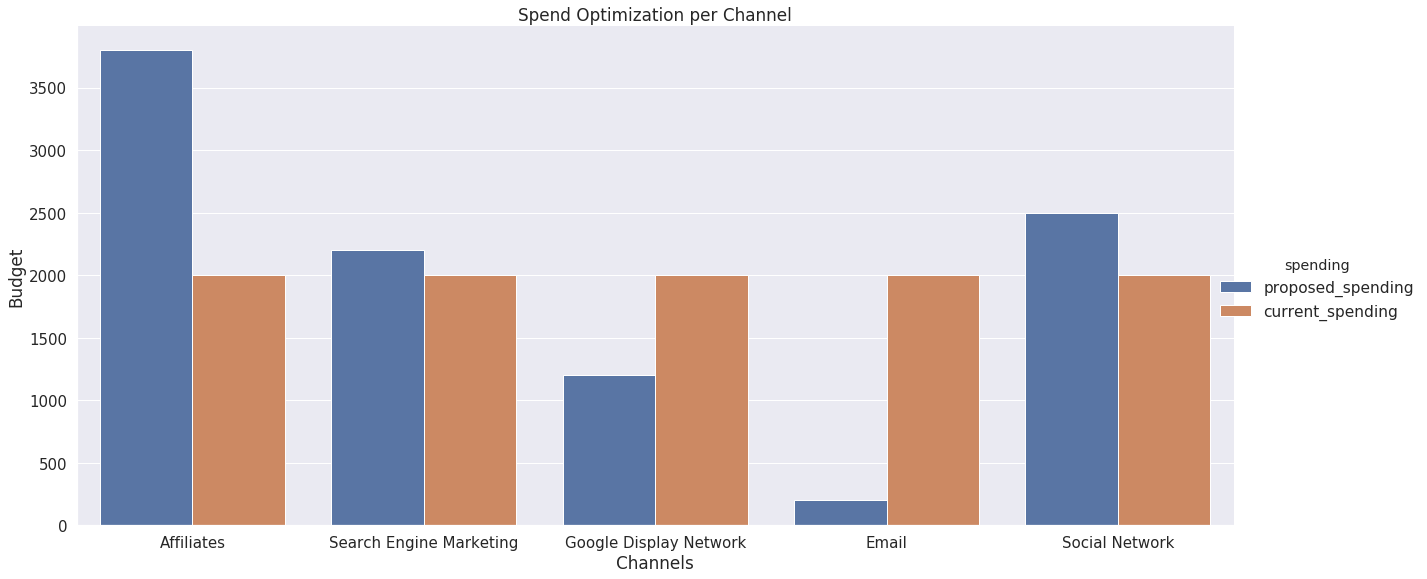

In [0]:
spend_optimisation_final_pd = spark.table("spend_optimisation_final").toPandas()

pt = sns.catplot(x='channel', y='budget', hue='spending', data=spend_optimisation_final_pd, kind='bar', aspect=4, ci=None)

plt.tick_params(labelsize=15)
pt.fig.set_figwidth(20)
pt.fig.set_figheight(9)
plt.title("Spend Optimization per Channel")
plt.ylabel("Budget")
plt.xlabel("Channels")